PID
---
A proportional–integral–derivative controller (PID controller or three-term controller) 

In [9]:
%matplotlib inline
import random
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class Robot(object):
    def __init__(self, length=20.0):
        """
        Creates robot and initializes location/orientation to 0, 0, 0.
        """
        self.x = 0.0
        self.y = 0.0
        self.orientation = 0.0
        self.length = length
        self.steering_noise = 0.0
        self.distance_noise = 0.0
        self.steering_drift = 0.0

    def set(self, x, y, orientation):
        """
        Sets a robot coordinate.
        """
        self.x = x
        self.y = y
        self.orientation = orientation % (2.0 * np.pi)

    def set_noise(self, steering_noise, distance_noise):
        """
        Sets the noise parameters.
        """
        # makes it possible to change the noise parameters
        # this is often useful in particle filters
        self.steering_noise = steering_noise
        self.distance_noise = distance_noise

    def set_steering_drift(self, drift):
        """
        Sets the systematical steering drift parameter
        """
        self.steering_drift = drift

    def move(self, steering, distance, tolerance=0.001, max_steering_angle=np.pi / 4.0):
        """
        steering = front wheel steering angle, limited by max_steering_angle(max 90 degree)
        distance = total distance driven, most be non-negative
        """
        if steering > max_steering_angle:
            steering = max_steering_angle
        if steering < -max_steering_angle:
            steering = -max_steering_angle
        if distance < 0.0:
            distance = 0.0

        # apply noise
        steering2 = random.gauss(steering, self.steering_noise)
        distance2 = random.gauss(distance, self.distance_noise)

        # apply steering drift
        steering2 += self.steering_drift

        # Execute motion
        turn = np.tan(steering2) * distance2 / self.length

        if abs(turn) < tolerance:
            # approximate by straight line motion
            self.x += distance2 * np.cos(self.orientation)
            self.y += distance2 * np.sin(self.orientation)
            self.orientation = (self.orientation + turn) % (2.0 * np.pi)
        else:
            # approximate bicycle model for motion
            radius = distance2 / turn
            cx = self.x - (np.sin(self.orientation) * radius)
            cy = self.y + (np.cos(self.orientation) * radius)
            self.orientation = (self.orientation + turn) % (2.0 * np.pi)
            self.x = cx + (np.sin(self.orientation) * radius)
            self.y = cy - (np.cos(self.orientation) * radius)

    def __repr__(self):
        return '[x=%.5f y=%.5f orient=%.5f]' % (self.x, self.y, self.orientation)

### P controll

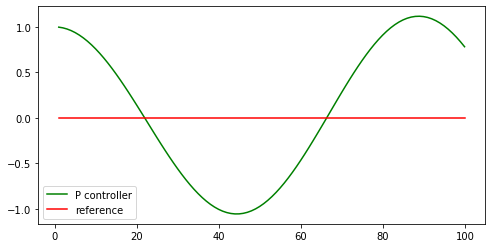

In [48]:
def run(robot, tau, n=100, speed=1.0):
    x_trajectory = []
    y_trajectory = []
    
    for _ in range(n):
        steering = -tau*robot.y
        robot.move(steering, speed)
        
        x_trajectory.append(robot.x)
        y_trajectory.append(robot.y)
    
    return x_trajectory, y_trajectory

# run - does a single control run
robot = Robot()
robot.set(0.0, 1.0, 0.0)

x_trajectory, y_trajectory = run(robot, 0.1)
n = len(x_trajectory)

fig, ax1 = plt.subplots(1, 1, figsize=(8, 4))
ax1.plot(x_trajectory, y_trajectory, 'g', label='P controller')
ax1.plot(x_trajectory, np.zeros(n), 'r', label='reference')
plt.legend()

### PD controll

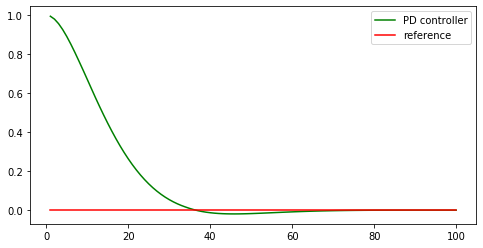

In [46]:
# run - does a single control run
robot = Robot()
robot.set(0, 1, 0)
# robot.set_steering_drift(10/180.*np.pi)

def run(robot, tau_p, tau_d, n=100, speed=1.0):
    x_trajectory = []
    y_trajectory = []
    
    prev_cte = robot.y
    for _ in range(n):
        dev = robot.y - prev_cte
        prev_cte = robot.y
        steer = -tau_p * robot.y - tau_d * dev
        robot.move(steer, speed)
        x_trajectory.append(robot.x)
        y_trajectory.append(robot.y)
        
    return x_trajectory, y_trajectory

x_trajectory, y_trajectory = run(robot, 0.2, 3)
n = len(x_trajectory)

fig, ax1 = plt.subplots(1, 1, figsize=(8, 4))
ax1.plot(x_trajectory, y_trajectory, 'g', label='PD controller')
ax1.plot(x_trajectory, np.zeros(n), 'r', label='reference')
plt.legend()

### PID

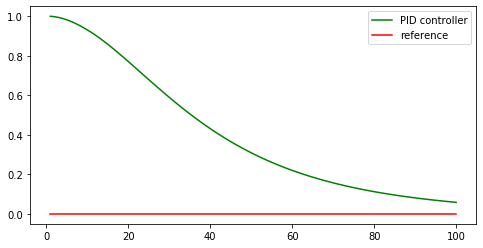

In [45]:
robot = Robot()
robot.set(0, 1, 0)
robot.set_steering_drift(10/180.*np.pi)  # add drift bias

def run(robot, tau_p, tau_d, tau_i, n=100, speed=1.0):
    x_trajectory = []
    y_trajectory = []
    
    prev_cte = robot.y
    sum_cte = 0
    for _ in range(n):
        sum_cte += robot.y
        dev = robot.y - prev_cte
        prev_cte = robot.y
        steer = -tau_p * robot.y - tau_d * dev - tau_i*sum_cte
        robot.move(steer, speed)
        x_trajectory.append(robot.x)
        y_trajectory.append(robot.y)
        
    return x_trajectory, y_trajectory


x_trajectory, y_trajectory = run(robot, 0.2, 3.0, 0.004)
n = len(x_trajectory)

fig, ax1 = plt.subplots(1, 1, figsize=(8, 4))
ax1.plot(x_trajectory, y_trajectory, 'g', label='PID controller')
ax1.plot(x_trajectory, np.zeros(n), 'r', label='reference')
plt.legend()

### Parameter Tuning
Twiddle

In [42]:
def make_robot():
    """
    Resets the robot back to the initial position and drift.
    You'll want to call this after you call `run`.
    """
    robot = Robot()
    robot.set(0.0, 1.0, 0.0)
    robot.set_steering_drift(10.0 / 180.0 * np.pi)
    return robot


def run(robot, params, n=100, speed=1.0):
    x_trajectory = []
    y_trajectory = []
    err = 0
    prev_cte = robot.y
    int_cte = 0
    for i in range(2 * n):
        cte = robot.y
        diff_cte = cte - prev_cte
        int_cte += cte
        prev_cte = cte
        steer = -params[0] * cte - params[1] * diff_cte - params[2] * int_cte
        robot.move(steer, speed)
        x_trajectory.append(robot.x)
        y_trajectory.append(robot.y)
        if i >= n:
            err += cte ** 2
    return x_trajectory, y_trajectory, err / n


# Make this tolerance bigger if you are timing out!
def twiddle(tol=0.2): 
    n = 0
    p = [0.0, 0.0, 0.0]
    dp = [1.0, 1.0, 1.0]
    
    robot = make_robot()
    x_trajectory, y_trajectory, best_err = run(robot, p)  # initial err
    
    while sum(dp) >= tol:
        for i in range(len(p)):
            robot = make_robot()
            p[i] += dp[i]
            _, _, err = run(robot, p)
            if err < best_err:
                best_err = err
                dp[i] *= 1.1
            else:
                p[i] -= 2*dp[i]  # reverse the search direction
                robot = make_robot()
                _, _, err = run(robot, p)
                if err < best_err:
                    best_err = err
                    dp[i] *= 1.1
                else:
                    p[i] += dp[i]
                    dp[i] *= 0.9  # narrow the search range
            n += 1
        if n % 5 == 0:
            print("best err {} | params {} | dparams {}".format(best_err, p, dp))
    
    return p, best_err


params, err = twiddle()
print("Final twiddle error = {}".format(err))

best err 0.0016645945527960432 | params [4.276900000000001, 4.641000000000002, 0.0] | dparams [1.3176900000000005, 1.3176900000000007, 0.5904900000000002]
best err 1.1769110322775785e-06 | params [7.059993049000001, 12.685629219000006, 0.43046721000000016] | dparams [1.7363069361000012, 2.122152921900002, 0.4261625379000002]
best err 1.0756081254381531e-12 | params [3.41374848319, 10.393491848055813, 0.4304672100000001] | dparams [1.5315789852644504, 2.287914286629612, 0.25164471700457114]
best err 8.128577728545796e-13 | params [3.413748483190001, 12.246702420225802, 0.4304672100000001] | dparams [0.9043820750088055, 1.6512106198034573, 0.14859368894402925]
best err 2.6262743718878566e-13 | params [3.413748483190001, 12.246702420225798, 0.5790608989440293] | dparams [0.5340285714719497, 0.9750233588877438, 0.10724155124779536]
best err 1.1111315964316227e-15 | params [2.933122768865246, 11.272654084696942, 0.49316041639454533] | dparams [0.3854137603170209, 1.051182433450466, 0.115618

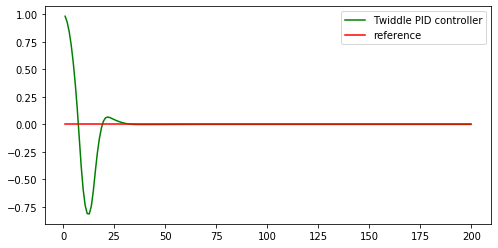

In [44]:
robot = make_robot()
x_trajectory, y_trajectory, err = run(robot, params)
n = len(x_trajectory)

fig, ax1 = plt.subplots(1, 1, figsize=(8, 4))
ax1.plot(x_trajectory, y_trajectory, 'g', label='Twiddle PID controller')
ax1.plot(x_trajectory, np.zeros(n), 'r', label='reference')
plt.legend()